In [1]:
%matplotlib inline

In [2]:
from collections import namedtuple
import os
os.environ['SLURM'] = '1'
# os.environ['BOARD'] = 'loihimh2'
os.environ['LMTOPTIONS'] = '--skip-power=1'

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import nengo
import nengo_dl
import nengo_loihi
from nengo_loihi.inputs import DVSFileChipNode  # branch: dvs-file-cores

from pytry.read import text
    
import davis_tracking
print(davis_tracking.__file__)

/home/arvoelke/.conda/envs/nx085/lib/python3.5/site-packages/nengo_dl/version.py:32: UserWarning: This version of `nengo_dl` has not been tested with your `nengo` version (3.0.0.dev0). The latest fully supported version is 2.8.0.
  ((nengo.version.version,) + latest_nengo_version))


/home/arvoelke/git/davis_tracking/davis_tracking/__init__.py


In [3]:
# model file generated via:
# repo: https://github.com/tcstewar/davis_tracking/
# branch: nengo_spiking
# pytry track_deep_heat_spiking.py --n_epochs=200 --n_data=-1 --test_set=one --save_params=True --seed=0 --saturation=1000000000 --n_features_1=3 --n_parallel=1 --max_rate=8000

trained = os.path.abspath("data/TrackingTrial#20190621-114844-871ad8af")
pdict = text("%s.txt" % trained)
p = namedtuple("Params", pdict.keys())(*pdict.values())
params = np.load("%s.params.npy" % trained, allow_pickle=True)

print(pdict)

{'augment': False, 'seed': 0, 'n_features_1': 3, 'saturation': 1000000000, 'decay_time': 0.01, 'spatial_size': 12, 'max_n_neurons': 14080, 'test_targets_raw': array([list([18.5, 28.81851852, 5.0, 0.2]),
       list([18.4, 28.63703704, 5.0, 0.2]),
       list([18.3, 28.45555556, 5.0, 0.2]), Ellipsis,
       list([37.61414141, 27.37373737, 5.0, 0.2]),
       list([37.60707071, 27.38686869, 5.0, 0.2]),
       list([37.6, 27.4, 5.0, 0.2])], dtype=object), 'spatial_stride': 6, 'n_data': -1, 'rmse_test': array([ 8.3313161 , 10.20100532]), 'load_params_from': '', 'separate_channels': True, 'test_set': 'one', 'n_parallel': 1, 'learning_rate': 0.001, 'save_params': True, 'n_epochs': 200, 'minibatch_size': 200, 'test_loss': 1.3089299, 'max_rate': 8000, 'n_features_2': 10, 'target_peak': array([list([15.5, 25.5]), list([15.5, 25.5]), list([15.5, 25.5]),
       Ellipsis, list([34.5, 24.5]), list([34.5, 24.5]),
       list([34.5, 24.5])], dtype=object), 'normalize': False, 'dataset_dir': '../datase

In [4]:
testfile = '../dataset/retinaTest95.events'

dt = 0.001
times, images, targets = davis_tracking.load_data(
    testfile,
    dt=dt,
    decay_time=p.decay_time,
    separate_channels=p.separate_channels,
    saturation=p.saturation,
    merge=p.merge)

times.shape, images.shape, targets.shape

((1570,), (1570, 72, 48), (1570, 4))

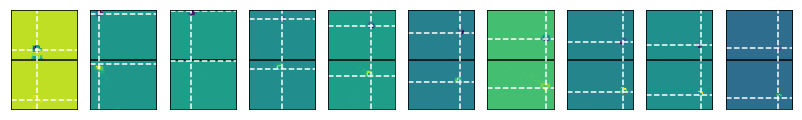

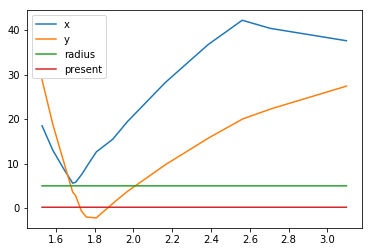

In [5]:
N = 10
plt.figure(figsize=(14,8))
indices = np.linspace(0, len(times)-1, N).astype(int)
for i, index in enumerate(indices):
    plt.subplot(1, N, i+1)
    plt.imshow(images[index]) #, vmin=-1, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.axhline(targets[index,1], c='w', ls='--')
    plt.axhline(images.shape[1]//2, c='k')
    plt.axhline(targets[index,1]+images.shape[1]//2, c='w', ls='--')
    plt.axvline(targets[index,0], c='w', ls='--')

plt.figure()
plt.plot(times, targets)
plt.legend(['x', 'y', 'radius', 'present'])

plt.show()

In [6]:
# copied over from track_deep_heat.py:
strip_edges = 3  #  the number of edge pixels to remove due to convolution
assert p.separate_channels
shape = (2, 180//p.merge, 240//p.merge)
output_shape = shape[1]-strip_edges*2, shape[2]-strip_edges*2

In [10]:
# this is a hack to handle the fact that the CNN
# was trained with filtered events while
# spikes are implicitly scaled by 1/dt
scale_input_by_dt = True
tau_probe = 0.02

with nengo.Network() as model:
    inp = DVSFileChipNode(filename=testfile, t_start=times[0], pool=(p.merge, p.merge),
                          channels_last=False)
    assert inp.dt == dt

    #inp = nengo.Node(output=nengo.processes.PresentInput(
    #    images.reshape(images.shape[0], -1), dt))
    
    #p_inp = nengo.Probe(inp, synapse=p.decay_time)
    
    # force `out` to run on the host so that the merged
    # output is stapled together on the host, and then
    # use_neurons for the final layer because nengo_loihi doesn't
    # currently support probing a convolutional tranform
    out = nengo.Node(lambda t, x: x, size_in=np.prod(output_shape))
    
    convnet = davis_tracking.ConvNet(nengo.Network(), max_rate=p.max_rate)
    
    convnet.input = inp
    
    convnet.make_input_layer(
            shape,
            spatial_stride=(p.spatial_stride, p.spatial_stride), 
            spatial_size=(p.spatial_size, p.spatial_size))
    
    #nengo.Connection(inp, convnet.input)
    
    init = params[2]['transform'].init #if params is not None else nengo.dists.Uniform(-1, 1)
    if scale_input_by_dt:
        init = init * dt
    convnet.make_middle_layer(n_features=p.n_features_1, n_parallel=p.n_parallel, n_local=1,
                              kernel_stride=(1,1), kernel_size=(3,3), init=init)
    init = params[3]['transform'].init #if params is not None else nengo.dists.Uniform(-1, 1)
    convnet.make_middle_layer(n_features=p.n_features_2, n_parallel=p.n_parallel, n_local=1,
                              kernel_stride=(1,1), kernel_size=(3,3), init=init)
    init = params[4]['transform'].init #if params is not None else nengo.dists.Uniform(-1, 1)
    convnet.make_middle_layer(n_features=1, n_parallel=p.n_parallel, n_local=1,
                              kernel_stride=(1,1), kernel_size=(3,3), init=init, use_neurons=True)
    convnet.make_merged_output(output_shape)
    nengo.Connection(convnet.output, out)
    
    #probes = []
    #for ensemble in model.all_ensembles:
    #    probes.append(
    #        nengo.Probe(ensemble.neurons, synapse=None))

    p_out = nengo.Probe(out, synapse=tau_probe)

    if params is not None:
        assert np.allclose(params[0]['gain'], p.max_rate, atol=1e-5)
        assert np.allclose(params[1]['gain'], p.max_rate, atol=1e-5)
        
        # Copied over from commit 909c38f5f35b1c31794d7cb8282eccb247746774
        def assign_bias(edge, full_bias, layer, n_features, stride):
            used = np.zeros_like(full_bias)
            start_x = 0
            start_y = 0
            w = p.spatial_size - edge
            h = p.spatial_size - edge
            full_w = shape[2] - edge
            full_h = shape[1] - edge
            assert len(full_bias) == full_w*full_h*n_features
            for row in layer:
                for patches in row:
                    for patch in patches:
                        bias = np.zeros(patch.size_out)
                        assert patch.size_out == w*h*n_features
                        for i in range(w):
                            for j in range(h):
                                for k in range(n_features):
                                    local_index = i + j*w + k*h*w
                                    full_index = (start_x + i) + (start_y+j)*full_w + k*(full_w*full_h)
                                    bias[local_index] = full_bias[full_index]
                                    used[full_index] += 1
                        patch.ensemble.bias = bias
                        patch.ensemble.gain = np.ones(patch.size_out)*100
                    start_x += stride
                start_x = 0
                start_y += stride
        
        # TODO: figure out why this isn't making things better:
        # assign_bias(edge=2, full_bias=params[0]['bias'], layer=convnet.layers[1], n_features=p.n_features_1, stride=p.spatial_stride)
        # assign_bias(edge=4, full_bias=params[1]['bias'], layer=convnet.layers[2], n_features=p.n_features_2, stride=p.spatial_stride)

In [11]:
convert_to_spiking = True
add_synapses = 0.001  # p.decay_time

print("=====================")

if convert_to_spiking:
    n_ensembles = 0
    for ens in model.all_ensembles:
        if isinstance(ens.neuron_type, nengo.RectifiedLinear):
            assert ens.neuron_type.amplitude == 1 / p.max_rate, ens.neuron_type.amplitude
            n_ensembles += 1
            ens.neuron_type = nengo.SpikingRectifiedLinear(
                amplitude=ens.neuron_type.amplitude)
    print("Changed %d ensembles" % n_ensembles)
    
if add_synapses is not None:    
    n_synapses = 0
    for conn in model.all_connections:
        if conn.synapse is None:
            n_synapses += 1
            conn.synapse = add_synapses
    print("Changed %d synapses" % n_synapses)

print("=====================")

Changed 105 ensembles
Changed 175 synapses


In [12]:
from nengo_loihi.hardware.allocators import GreedyChip

with nengo_loihi.Simulator(model, dt=dt, precompute=True, target="loihi",
                           hardware_options={'allocator': GreedyChip(2)}) as sim:
#with nengo.Simulator(model, dt=dt) as sim:
    sim.run_steps(len(times))

/home/arvoelke/git/nengo-loihi/nengo_loihi/simulator.py:170: UserWarning: No precomputable objects. Setting precompute=True has no effect.
  warnings.warn("No precomputable objects. Setting "


time 2: 100 spikes
time 3: 116 spikes
time 4: 97 spikes
time 5: 102 spikes
time 6: 108 spikes
time 7: 90 spikes
time 8: 90 spikes
time 9: 83 spikes
time 10: 85 spikes
time 11: 85 spikes
time 12: 86 spikes
time 13: 78 spikes
time 14: 79 spikes
time 15: 73 spikes
time 16: 95 spikes
time 17: 84 spikes
time 18: 80 spikes
time 19: 93 spikes
time 20: 87 spikes
time 21: 84 spikes
time 22: 79 spikes
time 23: 83 spikes
time 24: 104 spikes
time 25: 95 spikes
time 26: 103 spikes
time 27: 91 spikes
time 28: 79 spikes
time 29: 85 spikes
time 30: 90 spikes
time 31: 90 spikes
time 32: 98 spikes
time 33: 83 spikes
time 34: 94 spikes
time 35: 92 spikes
time 36: 89 spikes
time 37: 467 spikes
time 38: 90 spikes
time 39: 69 spikes
time 40: 74 spikes
time 41: 85 spikes
time 42: 105 spikes
time 43: 85 spikes
time 44: 71 spikes
time 45: 101 spikes
time 46: 88 spikes
time 47: 81 spikes
time 48: 89 spikes
time 49: 240 spikes
time 50: 50 spikes
time 51: 86 spikes
time 52: 106 spikes
time 53: 91 spikes
time 54: 

time 733: 261 spikes
time 734: 31 spikes
time 735: 21 spikes
time 736: 35 spikes
time 737: 34 spikes
time 738: 30 spikes
time 739: 25 spikes
time 740: 33 spikes
time 741: 30 spikes
time 742: 27 spikes
time 743: 35 spikes
time 744: 29 spikes
time 745: 102 spikes
time 746: 16 spikes
time 747: 20 spikes
time 748: 28 spikes
time 749: 24 spikes
time 750: 35 spikes
time 751: 26 spikes
time 752: 31 spikes
time 753: 31 spikes
time 754: 23 spikes
time 755: 32 spikes
time 756: 28 spikes
time 757: 36 spikes
time 758: 34 spikes
time 759: 30 spikes
time 760: 32 spikes
time 761: 29 spikes
time 762: 32 spikes
time 763: 38 spikes
time 764: 30 spikes
time 765: 28 spikes
time 766: 34 spikes
time 767: 40 spikes
time 768: 35 spikes
time 769: 37 spikes
time 770: 27 spikes
time 771: 37 spikes
time 772: 32 spikes
time 773: 22 spikes
time 774: 30 spikes
time 775: 40 spikes
time 776: 38 spikes
time 777: 34 spikes
time 778: 41 spikes
time 779: 29 spikes
time 780: 35 spikes
time 781: 32 spikes
time 782: 40 spike

time 1790: 3 spikes
time 1791: 5 spikes
time 1792: 9 spikes
time 1793: 4 spikes
time 1794: 44 spikes
time 1795: 3 spikes
time 1796: 2 spikes
time 1797: 2 spikes
time 1798: 2 spikes
time 1799: 3 spikes
time 1800: 6 spikes
time 1801: 2 spikes
time 1802: 5 spikes
time 1803: 6 spikes
time 1804: 1 spikes
time 1805: 4 spikes
time 1806: 4 spikes
time 1807: 10 spikes
time 1808: 8 spikes
time 1809: 2 spikes
time 1810: 5 spikes
time 1811: 9 spikes
time 1812: 1 spikes
time 1813: 1 spikes
time 1814: 7 spikes
time 1815: 5 spikes
time 1816: 4 spikes
time 1817: 6 spikes
time 1818: 8 spikes
time 1819: 4 spikes
time 1820: 4 spikes
time 1821: 10 spikes
time 1822: 5 spikes
time 1823: 3 spikes
time 1824: 7 spikes
time 1825: 6 spikes
time 1826: 6 spikes
time 1827: 5 spikes
time 1828: 3 spikes
time 1829: 5 spikes
time 1830: 6 spikes
time 1831: 108 spikes
time 1832: 48 spikes
time 1833: 26 spikes
time 1834: 6 spikes
time 1835: 1 spikes
time 1836: 4 spikes
time 1837: 3 spikes
time 1838: 5 spikes
time 1839: 3 

/home/arvoelke/git/nxsdk/nxsdk-0.8.5/nxsdk/graph/nxinputgen/../../snips/
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.42.0.100:45339
INFO:DRV:      Host server up..............Done 0.21s
INFO:DRV:      Encoding axons/synapses.....Done 26.16s
INFO:DRV:      Compiling snips.............Done 0.43s
INFO:DRV:      Encoding probes.............Done 5.74ms
INFO:DRV:      Booting up..................Done 2.61s
INFO:DRV:      Transferring probes.........Done 0.03s
INFO:DRV:      Configuring registers.......Done 4.36s
INFO:DRV:      Transferring spikes.........Done 0.36s
INFO:DRV:      Executing...................Done 8.01s
INFO:DRV:      Processing timeseries.......Done 0.61s
INFO:DRV:  Executor: 1570 timesteps........Done 13.38s


In [13]:
len(sim.model.split._chip_objects)

106

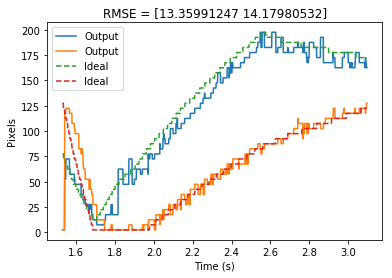

In [14]:
data = sim.data[p_out]  # [:len(targets_test)]

targets_heatmap = davis_tracking.make_heatmap(
    targets, merge=p.merge, strip_edges=strip_edges).reshape(len(targets), -1)

data_peak = np.array([davis_tracking.find_peak(img.reshape(output_shape)) for img in data])
target_peak = np.array([davis_tracking.find_peak(img.reshape(output_shape)) for img in targets_heatmap])

rmse_test = np.sqrt(np.mean((target_peak-data_peak)**2, axis=0))*p.merge          
if plt:
    plt.title("RMSE = %s" % (rmse_test,))
    plt.plot(times, data_peak*p.merge, label="Output")
    plt.plot(times, target_peak*p.merge, ls='--', label="Ideal")
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Pixels")
    plt.show()
    #plt.plot((targets-strip_edges)*p.merge, ls=':')

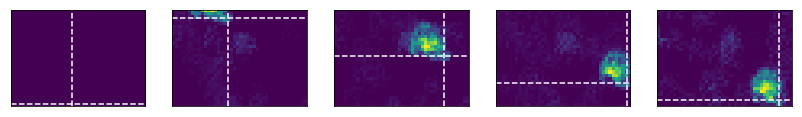

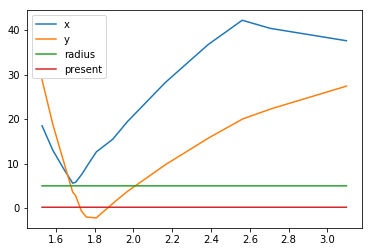

In [15]:
N = 5
plt.figure(figsize=(14,8))
indices = np.linspace(0, len(times)-1, N).astype(int)
for i, index in enumerate(indices):
    plt.subplot(1, N, i+1)
    plt.imshow(data[index].reshape(output_shape))
    #plt.imshow(images[index])
    #plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.axhline(targets[index,1], c='w', ls='--')
    #plt.axhline(images.shape[1]//2, c='k')
    #plt.axhline(targets[index,1]+images.shape[1]//2, c='w', ls='--')
    plt.axvline(targets[index,0], c='w', ls='--')

plt.figure()
plt.plot(times, targets)
plt.legend(['x', 'y', 'radius', 'present'])

plt.show()

AssertionError: probed object not found

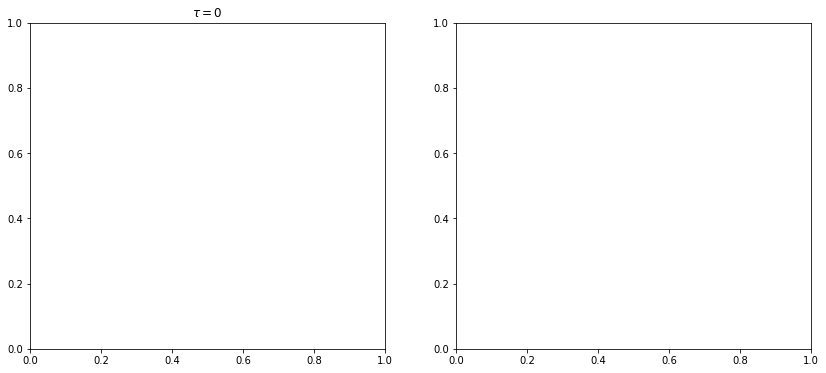

In [16]:
taus = [0, p.decay_time]
fig, ax = plt.subplots(1, len(taus), figsize=(14, 6))

R = []
colors = np.zeros((len(times), 4))

for i, tau in enumerate(taus):
    ax[i].set_title(r"$\tau = %s$" % tau)
    syn = nengo.Lowpass(tau)
    for j in range(len(probes)):
        a = sim.data[probes[j]] / ens.neuron_type.amplitude
        R.append(np.count_nonzero(a) / a.size / dt)
        #plt.show()
        y = syn.filt(np.mean(a, axis=1), dt=dt, y0=0)
        #colors[:, :3] = j / len(probes)
        #assert len(colors) == len(y)
        ax[i].plot(sim.trange(), y)#, c=colors.tolist())
plt.show()

plt.figure()
plt.hist(R)
plt.show()